In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# Cargar y limpiar datos
# ---------------------------
df_train = pd.read_parquet("../../data/train/train_con_outliers.parquet")
columns_to_drop = [
    "media_diff_1h", "media_diff_45m", "media_diff_20m", "media_diff_10m", "media_diff_5m",
    "despegues_previos_1h", "despegues_previos_45m", "despegues_previos_20m", "despegues_previos_10m", "despegues_previos_5m",
    'distancias_holdings_0', 'distancias_holdings_1', 'distancias_holdings_2', 'distancia_en_pista_0', 'distancia_en_pista_1',
    'distancia_yendo_a_pista_0', 'distancia_yendo_a_pista_1', 'distancia_yendo_a_pista_2',
    'tiempo_holding_0', 'tiempo_holding_1', 'tiempo_holding_2',
    "temp", "wind_shear"
]
df_train = df_train.drop(columns=columns_to_drop)
if 'ts' in df_train.columns:
    df_train['day'] = pd.to_datetime(df_train['ts']).dt.date
else:
    print("ADVERTENCIA: No se encontró 'ts'. Usando división aleatoria.")
    df_train['day'] = np.random.randint(1, 10, size=len(df_train))

target = 'tiempo_hasta_despegue'
features = [c for c in df_train.columns if c not in (target, 'day', 'ts')]

X_train = df_train[features]
y_train = df_train[target]

# ---------------------------
# Definir segmentación
# ---------------------------
def assign_segment(row):
    if (row['holding_ocupado']==0 and row['pista_ocupada']==0 and row['en_camino_antes']==0): return 'todo_libre'
    elif (row['holding_ocupado']==0 and row['pista_ocupada']==1 and row['en_camino_antes']==0): return 'solo_pista'
    elif (row['holding_ocupado']==1 and row['pista_ocupada']==0 and row['en_camino_antes']==0): return 'solo_holding'
    elif (row['holding_ocupado']==0 and row['pista_ocupada']==0 and row['en_camino_antes']==1): return 'solo_camino'
    else: return 'multiple'

# ---------------------------
# Preparar datos segmentados
def create_segmented_data(df):
    df = df.copy().reset_index(drop=True)
    df['segment'] = df.apply(assign_segment, axis=1)
    segments = {}
    for seg in df['segment'].unique():
        sub = df[df['segment']==seg]
        segments[seg] = {
            'X': sub.drop(columns=[target, 'segment', 'runway']),
            'y': sub[target],
            'count': len(sub)
        }

    return segments

train_segments = {}
for runway in X_train['runway'].unique():
    df_r = pd.concat([X_train, y_train], axis=1)
    df_r = df_r[df_r['runway']==runway]
    train_segments[f'runway_{int(runway)}'] = create_segmented_data(df_r)

# ---------------------------
# Grid Search: parámetros a explorar
# ---------------------------
param_grid = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [2, 3, 4, 5, 6],        
    'learning_rate': [0.05, 0.1],   
    'subsample': [0.9, 1.0]         
}

# ---------------------------
# Entrenar modelos por segmento
# ---------------------------
models = {}
for runway, segs in train_segments.items():
    models[runway] = {}
    for seg_name, data in segs.items():
        if data['count'] > 10:
            print(f"GridSearch para {runway}-{seg_name} ({data['count']} muestras)...")
            tscv = TimeSeriesSplit(n_splits=3) 
            gs = GridSearchCV(
                GradientBoostingRegressor(random_state=42),
                param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
            gs.fit(data['X'], data['y'])
            models[runway][seg_name] = gs.best_estimator_
            print(f"  Mejor params: {gs.best_params_}")
        else:
            models[runway][seg_name] = None
            print(f"Insuficientes datos para {runway}-{seg_name}: {data['count']} muestras")

# Modelo general
print("Entrenando modelo general (log-space)...")
tscv = TimeSeriesSplit(n_splits=3) 
gs_general = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
gs_general.fit(X_train.drop(columns=['runway']), y_train)
general_model = gs_general.best_estimator_
print(f"Mejores params (general): {gs_general.best_params_}\n")

GridSearch para runway_3-solo_pista (17872 muestras)...
  Mejor params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.9}
GridSearch para runway_3-todo_libre (5822 muestras)...
  Mejor params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9}
GridSearch para runway_3-solo_holding (697 muestras)...
  Mejor params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50, 'subsample': 1.0}
GridSearch para runway_3-solo_camino (2880 muestras)...
  Mejor params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.9}
GridSearch para runway_3-multiple (5798 muestras)...
  Mejor params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'subsample': 0.9}
GridSearch para runway_2-solo_camino (494 muestras)...
  Mejor params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
GridSearch para runway_2-solo_pista (7869 muestras)...
  Mejor params: {'learning_rate': 0.05, 'max_depth'

=== Métricas Globales ===
MAE:  73.97
RMSE: 107.45
R²:   0.11

=== Métricas por Segmento ===
                     MAE   Count
segment                         
multiple       93.415915  1867.0
solo_camino    79.688441   817.0
solo_holding  100.331384   295.0
solo_pista     62.524990  7301.0
todo_libre     85.629691  2988.0 

=== Métricas por Pista ===
              MAE   Count
runway                   
0.0     77.343045  1357.0
1.0     91.592491  3890.0
2.0     58.686717  2832.0
3.0     68.224535  5189.0 

=== Métricas por Holding Point ===
                      MAE   Count
holding_point                    
0.0             74.922044    31.0
2.0             66.201242  1170.0
3.0            147.053789   187.0
4.0             63.531664  1671.0
5.0             62.758380   584.0
6.0             40.534622   577.0
7.0             69.941869  2271.0
8.0             65.192487  2393.0
9.0             74.597017   494.0
10.0            74.937690  1421.0
11.0            99.691591  1279.0
12.0        

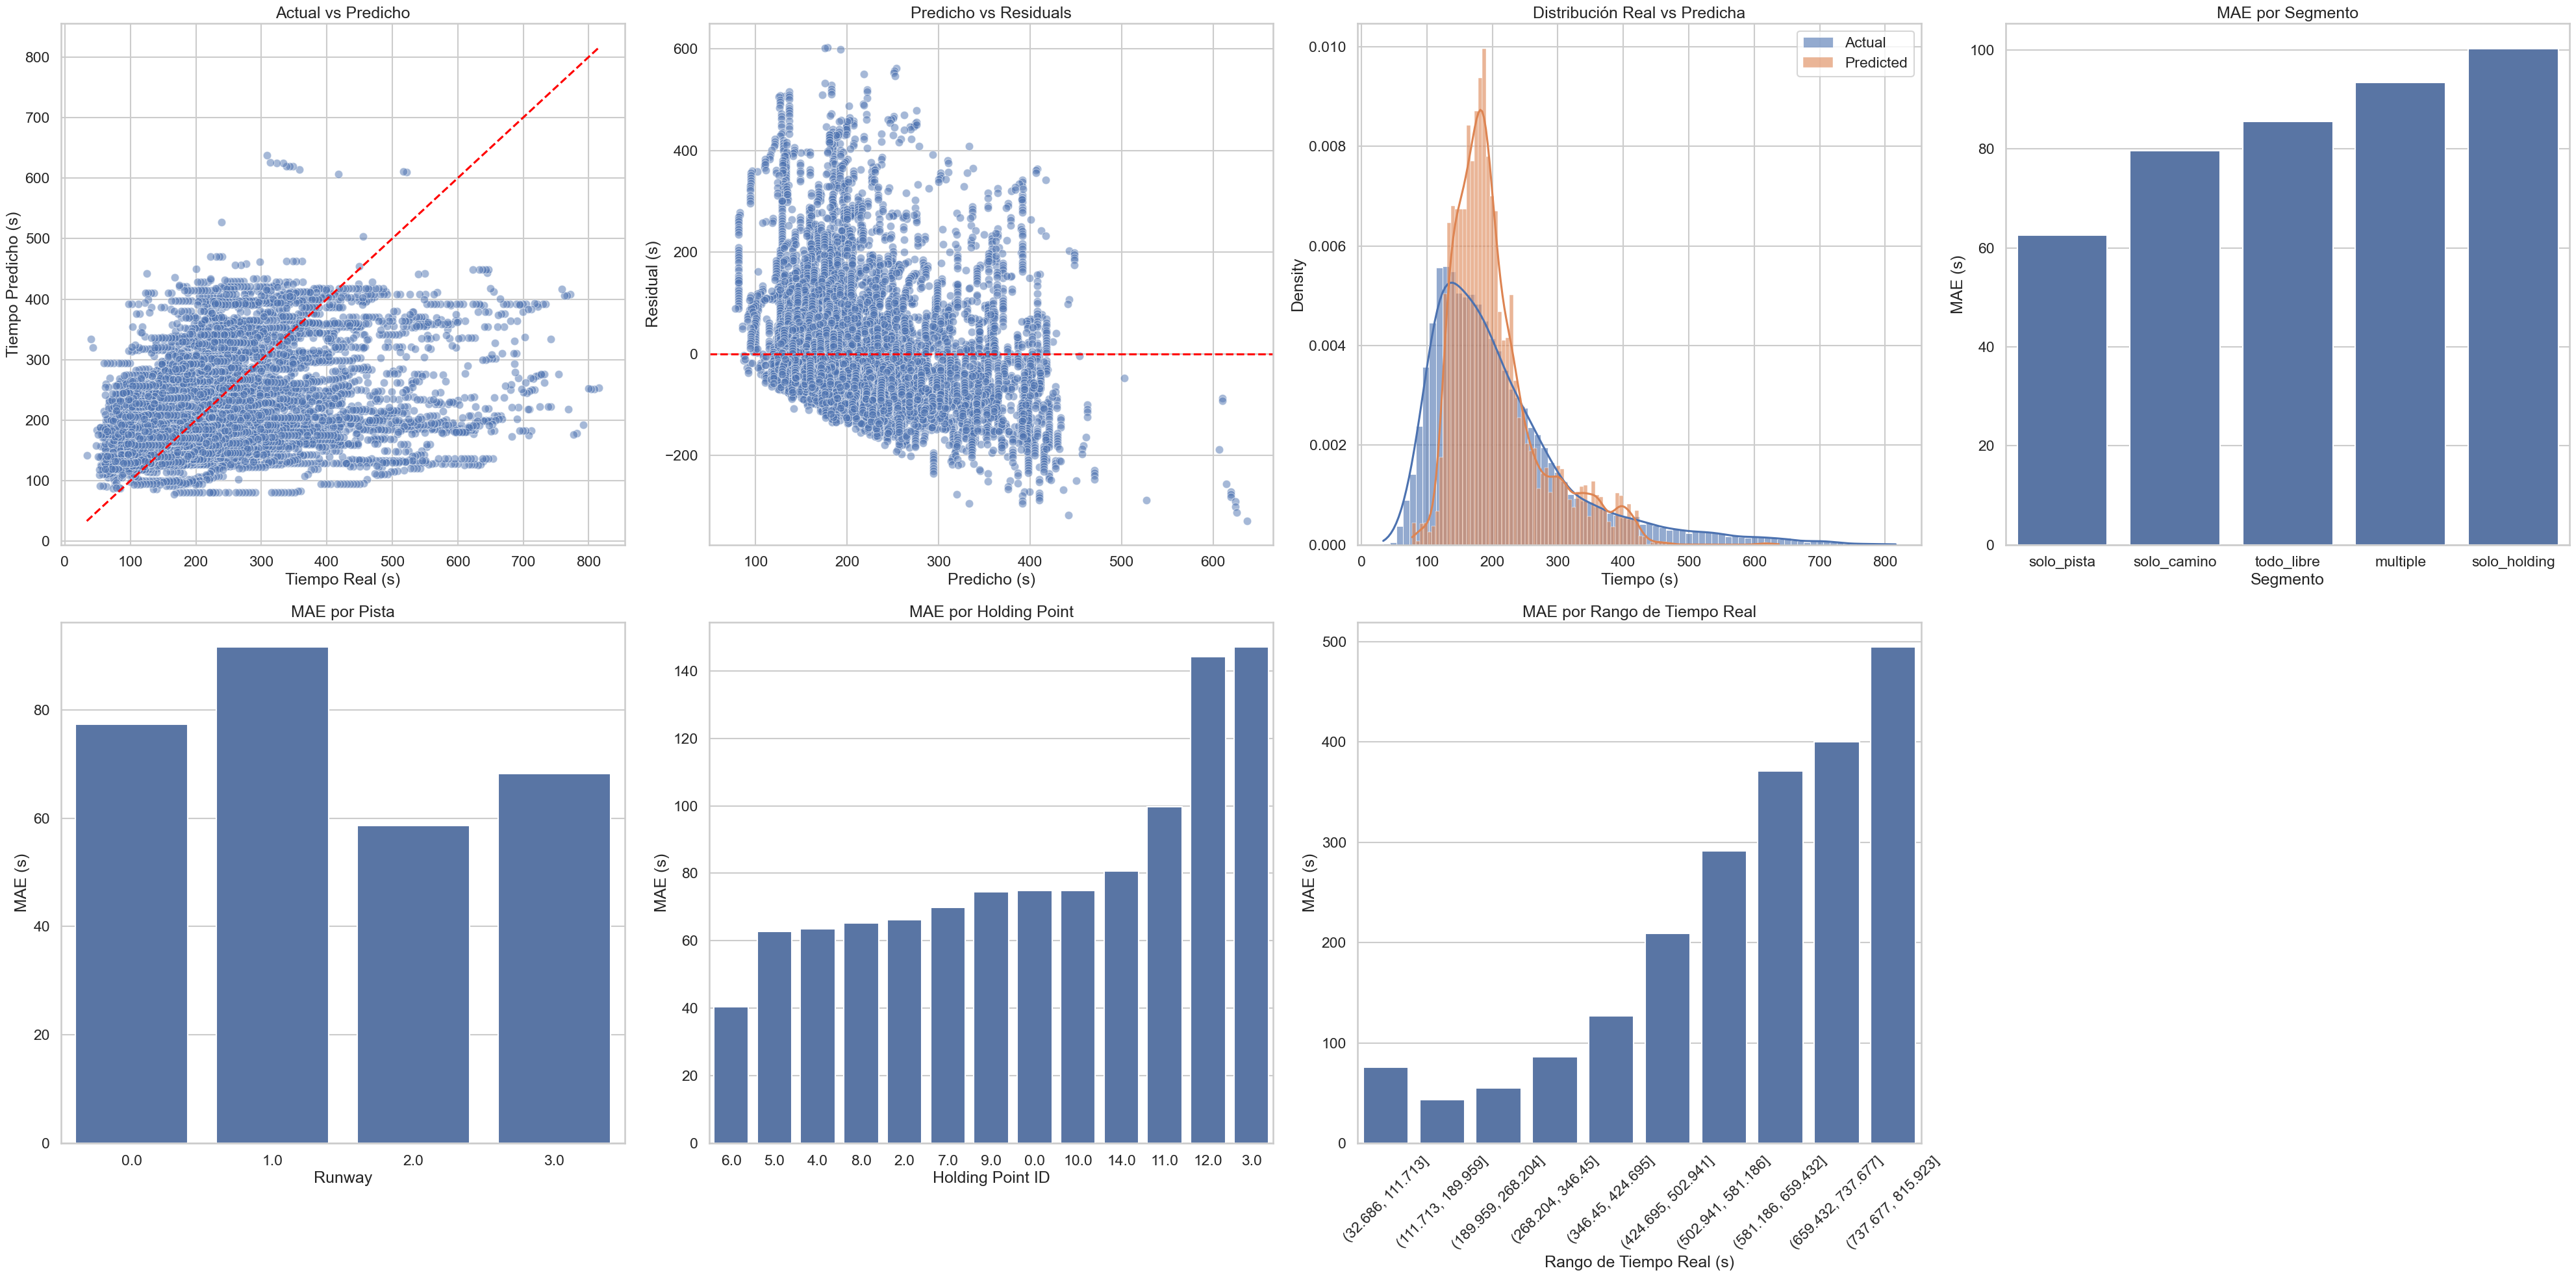

In [6]:
def predict_by_segment(X, y, models, general_model):
    df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    df['segment'] = df.apply(assign_segment, axis=1)
    results = []
    for _, row in df.iterrows():
        key = f"runway_{int(row['runway'])}"
        seg = row['segment']
        model = models.get(key, {}).get(seg) or general_model
        X_row = row.drop([target, 'segment', "runway"]).values.reshape(1, -1)
        pred = model.predict(X_row)[0]
        results.append({
            'actual': row[target], 'predicted': pred,
            'runway': row['runway'], 'segment': seg,
            'holding_point': row['holding_point_id'] if 'holding_point_id' in row.index else None
        })
    return pd.DataFrame(results)


# ---------------------------
# 1) Carga y predicción
# ---------------------------
df_test = pd.read_parquet("../../data/test/test_con_outliers.parquet").drop(columns=["ts"])
df_test = df_test.drop(columns=columns_to_drop, errors='ignore')

if target in df_test.columns:
    X_test = df_test.drop(columns=[target])
    y_test = df_test[target]
else:
    X_test = df_test
    y_test = pd.Series([np.nan] * len(df_test))

test_results = predict_by_segment(X_test, y_test, models, general_model)

# ---------------------------
# 2) Cálculo de métricas
# ---------------------------
# Globales
mae   = mean_absolute_error(test_results.actual,    test_results.predicted)
rmse  = np.sqrt(     mean_squared_error(test_results.actual, test_results.predicted))
r2    = r2_score(    test_results.actual,    test_results.predicted)

# Por segmento
seg_metrics    = test_results.groupby('segment').apply(
    lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
)
# Por pista (runway)
runway_metrics = test_results.groupby('runway').apply(
    lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
)
# Por holding_point (si existe)
if test_results['holding_point'].notna().any():
    hp_metrics = test_results.groupby('holding_point').apply(
        lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
    )
else:
    hp_metrics = None
# Por rango de tiempo real
test_results['actual_bin'] = pd.cut(test_results.actual, bins=10)
bin_metrics = test_results.groupby('actual_bin').apply(
    lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
)

import seaborn as sns

# ---------------------------
# 3) Impresión de resultados
# ---------------------------
print("=== Métricas Globales ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}\n")

print("=== Métricas por Segmento ===")
print(seg_metrics, "\n")

print("=== Métricas por Pista ===")
print(runway_metrics, "\n")

if hp_metrics is not None:
    print("=== Métricas por Holding Point ===")
    print(hp_metrics, "\n")

print("=== Métricas por Rango de Tiempo Real ===")
print(bin_metrics, "\n")

# ---------------------------
# 4) Gráficas con seaborn
# ---------------------------
sns.set(style="whitegrid", context="talk")
rows, cols = 2, 4
fig, axs = plt.subplots(rows, cols, figsize=(40, 20))
axs = axs.flatten()

# 1) Actual vs Predicho
sns.scatterplot(x="actual", y="predicted", data=test_results, ax=axs[0], alpha=0.5)
axs[0].plot(
    [test_results.actual.min(), test_results.actual.max()],
    [test_results.actual.min(), test_results.actual.max()],
    '--', color='red'
)
axs[0].set_title('Actual vs Predicho')
axs[0].set_xlabel('Tiempo Real (s)')
axs[0].set_ylabel('Tiempo Predicho (s)')

# 2) Predicho vs Residuals
test_results["residual"] = test_results["actual"] - test_results["predicted"]
sns.scatterplot(x="predicted", y="residual", data=test_results, ax=axs[1], alpha=0.5)
axs[1].axhline(0, linestyle='--', color='red')
axs[1].set_title('Predicho vs Residuals')
axs[1].set_xlabel('Predicho (s)')
axs[1].set_ylabel('Residual (s)')

# 3) Distribución Real vs Predicha con bins
sns.histplot(test_results["actual"], kde=True, stat="density", alpha=0.6, label='Actual', ax=axs[2])
sns.histplot(test_results["predicted"], kde=True, stat="density", alpha=0.6, label='Predicted', ax=axs[2])
axs[2].set_title('Distribución Real vs Predicha')
axs[2].set_xlabel('Tiempo (s)')
axs[2].legend()

# 4) MAE por Segmento
seg_order = seg_metrics["MAE"].sort_values().index
sns.barplot(x=seg_metrics.loc[seg_order].index, y=seg_metrics.loc[seg_order]["MAE"], ax=axs[3])
axs[3].set_title('MAE por Segmento')
axs[3].set_xlabel('Segmento')
axs[3].set_ylabel('MAE (s)')

# 5) MAE por Pista
sns.barplot(x=runway_metrics.index.astype(str), y=runway_metrics["MAE"], ax=axs[4])
axs[4].set_title('MAE por Pista')
axs[4].set_xlabel('Runway')
axs[4].set_ylabel('MAE (s)')

# 6) MAE por Holding Point
if hp_metrics is not None:
    hp_order = hp_metrics["MAE"].sort_values().index
    sns.barplot(x=hp_order.astype(str), y=hp_metrics.loc[hp_order]["MAE"], ax=axs[5])
    axs[5].set_title('MAE por Holding Point')
    axs[5].set_xlabel('Holding Point ID')
    axs[5].set_ylabel('MAE (s)')
else:
    axs[5].axis('off')

# 7) MAE por Rango de Tiempo Real
sns.barplot(x=bin_metrics.index.astype(str), y=bin_metrics["MAE"], ax=axs[6])
axs[6].set_title('MAE por Rango de Tiempo Real')
axs[6].set_xlabel('Rango de Tiempo Real (s)')
axs[6].set_ylabel('MAE (s)')
axs[6].tick_params(axis='x', rotation=45)

# Ocultar ejes vacíos
for ax in axs[7:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


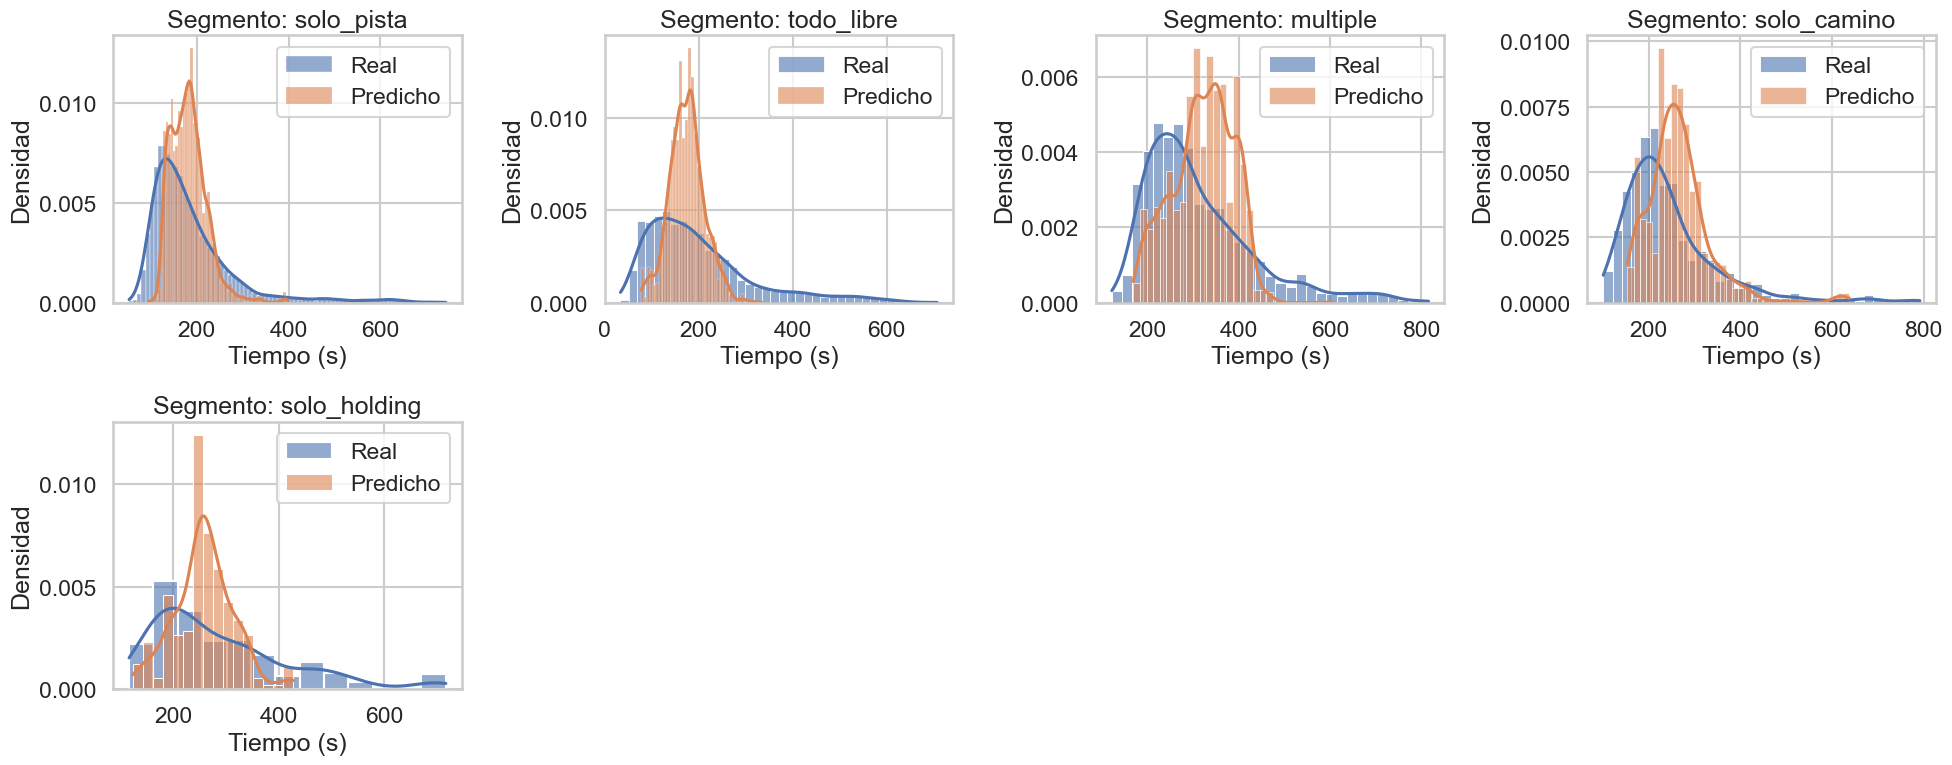

In [7]:
# ---------------------------
# 5) Distribución Real vs Predicha por Segmento
# ---------------------------
segments = test_results['segment'].unique()
n_seg = len(segments)
# Definimos un grid de subplots (4 columnas como ejemplo)
cols = 4
rows = int(np.ceil(n_seg / cols))
fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axs = axs.flatten()

for ax, seg in zip(axs, segments):
    df_seg = test_results[test_results['segment'] == seg]
    # Histograma real
    sns.histplot(
        df_seg["actual"],
        kde=True,
        stat="density",
        alpha=0.6,
        label='Real',
        ax=ax
    )
    # Histograma predicho
    sns.histplot(
        df_seg["predicted"],
        kde=True,
        stat="density",
        alpha=0.6,
        label='Predicho',
        ax=ax
    )
    ax.set_title(f'Segmento: {seg}')
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Densidad')
    ax.legend()

# Si hay ejes sobrantes, los ocultamos
for ax in axs[n_seg:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
